CT Reconstruction (ADMM Plug-and-Play Priors w/ BM3D, SVMBIR+Prox)
==================================================================

This example demonstrates the use of class
[admm.ADMM](../_autosummary/scico.optimize.rst#scico.optimize.ADMM) to
solve a tomographic reconstruction problem using the Plug-and-Play Priors
framework <cite data-cite="venkatakrishnan-2013-plugandplay2"/>, using BM3D
<cite data-cite="dabov-2008-image"/> as a denoiser and SVMBIR <cite data-cite="svmbir-2020"/> for
tomographic projection.

This version uses the data fidelity term as one of the ADMM g functionals,
and thus the optimization with respect to the data fidelity is able to
exploit the internal prox of the SVMBIRWeightedSquaredL2Loss functional.

In [1]:
import numpy as np

import jax

import matplotlib.pyplot as plt
import svmbir
from xdesign import Foam, discrete_phantom

import scico.numpy as snp
from scico import metric, plot
from scico.functional import BM3D, NonNegativeIndicator
from scico.linop import Diagonal, Identity
from scico.linop.radon_svmbir import ParallelBeamProjector, SVMBIRWeightedSquaredL2Loss
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Generate a ground truth image.

In [2]:
N = 256  # image size
density = 0.025  # attenuation density of the image
np.random.seed(1234)
x_gt = discrete_phantom(Foam(size_range=[0.05, 0.02], gap=0.02, porosity=0.3), size=N - 10)
x_gt = x_gt / np.max(x_gt) * density
x_gt = np.pad(x_gt, 5)
x_gt[x_gt < 0] = 0

Generate tomographic projector and sinogram.

In [3]:
num_angles = int(N / 2)
num_channels = N
angles = snp.linspace(0, snp.pi, num_angles, endpoint=False, dtype=snp.float32)
A = ParallelBeamProjector(x_gt.shape, angles, num_channels)
sino = A @ x_gt

Impose Poisson noise on sinogram. Higher max_intensity means less noise.

In [4]:
max_intensity = 2000
expected_counts = max_intensity * np.exp(-sino)
noisy_counts = np.random.poisson(expected_counts).astype(np.float32)
noisy_counts[noisy_counts == 0] = 1  # deal with 0s
y = -np.log(noisy_counts / max_intensity)

Reconstruct using default prior of SVMBIR <cite data-cite="svmbir-2020"/>.

In [5]:
weights = svmbir.calc_weights(y, weight_type="transmission")

x_mrf = svmbir.recon(
    np.array(y[:, np.newaxis]),
    np.array(angles),
    weights=weights[:, np.newaxis],
    num_rows=N,
    num_cols=N,
    positivity=True,
    verbose=0,
)[0]

Set up an ADMM solver.

In [6]:
y, x0, weights = jax.device_put([y, x_mrf, weights])

ρ = 10  # ADMM penalty parameter
σ = density * 0.26  # denoiser sigma

f = SVMBIRWeightedSquaredL2Loss(
    y=y, A=A, W=Diagonal(weights), scale=0.5, prox_kwargs={"maxiter": 5, "ctol": 0.0}
)
g0 = σ * ρ * BM3D()
g1 = NonNegativeIndicator()

solver = ADMM(
    f=None,
    g_list=[f, g0, g1],
    C_list=[Identity(x_mrf.shape), Identity(x_mrf.shape), Identity(x_mrf.shape)],
    rho_list=[ρ, ρ, ρ],
    x0=x0,
    maxiter=20,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": 1e-3, "maxiter": 100}),
    itstat_options={"display": True},
)

Run the solver.

In [7]:
print(f"Solving on {device_info()}\n")
x_bm3d = solver.solve()
hist = solver.itstat_object.history(transpose=True)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Prml Rsdl  Dual Rsdl  CG It  CG Res   
------------------------------------------------------
   0  4.59e+00  5.343e-01  5.343e-01      0  0.000e+00


   1  8.29e+00  3.666e-01  3.210e-01      1  4.420e-09


   2  1.14e+01  2.390e-01  2.150e-01      1  2.552e-09


   3  1.53e+01  1.556e-01  1.818e-01      1  2.398e-09


   4  1.84e+01  1.184e-01  1.356e-01      1  3.319e-09


   5  2.26e+01  1.014e-01  9.300e-02      1  1.059e-09


   6  2.52e+01  8.538e-02  6.392e-02      1  7.369e-10


   7  2.86e+01  6.768e-02  5.087e-02      1  5.308e-10


   8  3.24e+01  5.299e-02  4.447e-02      1  5.580e-10


   9  3.52e+01  4.373e-02  3.741e-02      1  3.866e-10


  10  3.94e+01  3.900e-02  2.976e-02      1  3.446e-10


  11  4.30e+01  3.536e-02  2.403e-02      1  2.699e-10


  12  4.64e+01  3.201e-02  2.064e-02      1  1.914e-10


  13  4.92e+01  2.903e-02  1.935e-02      1  1.784e-10


  14  5.33e+01  2.662e-02  1.798e-02      1  1.623e-10


  15  5.70e+01  2.471e-02  1.630e-02      1  1.753e-10


  16  6.01e+01  2.338e-02  1.497e-02      1  1.545e-10


  17  6.38e+01  2.211e-02  1.452e-02      1  1.260e-10


  18  6.72e+01  2.124e-02  1.432e-02      1  1.402e-10


  19  7.09e+01  2.006e-02  1.393e-02      1  1.410e-10


Show the recovered image.

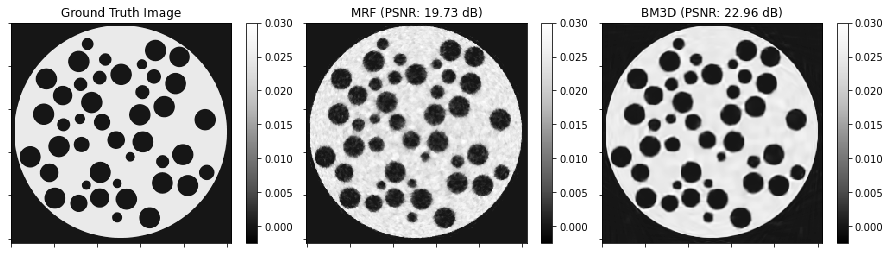

In [8]:
norm = plot.matplotlib.colors.Normalize(vmin=-0.1 * density, vmax=1.2 * density)
fig, ax = plt.subplots(1, 3, figsize=[15, 5])
plot.imview(img=x_gt, title="Ground Truth Image", cbar=True, fig=fig, ax=ax[0], norm=norm)
plot.imview(
    img=x_mrf,
    title=f"MRF (PSNR: {metric.psnr(x_gt, x_mrf):.2f} dB)",
    cbar=True,
    fig=fig,
    ax=ax[1],
    norm=norm,
)
plot.imview(
    img=x_bm3d,
    title=f"BM3D (PSNR: {metric.psnr(x_gt, x_bm3d):.2f} dB)",
    cbar=True,
    fig=fig,
    ax=ax[2],
    norm=norm,
)
fig.show()

Plot convergence statistics.

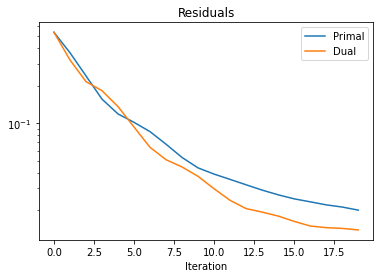

In [9]:
plot.plot(
    snp.vstack((hist.Prml_Rsdl, hist.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
)